# Attachnments and configurable blobs
This notebooks demonstrates the use of DataJoint's support for storing complex datatypes (blobs) and file attachments.

**blob** in the context of DataJoint refers to an attribute that can store complex data structures such as numeric arrays.

**attachment** refers to an attribute that can store an entire file with its filename, etc.

These features are currently in pre-release.  To enable them, use the following upgrade command

```shell
$ pip3 install --upgrade --pre datajoint
```

We also assume that the datajoint credentials are already saved and the S3 credentials are saved in `./s3-creds.json`. If you do not have these credentials, please obtain them before the demo.

## Imports and create the schema `common_attach`

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import os
import imageio
import requests
from ipywidgets import Image
import ipywidgets

import datajoint as dj

In [2]:
schema = dj.schema('common_attach')

Connecting dimitri@ucsd-demo-db.datajoint.io:3306


## Lookup of images on the web
We create a lookup table, WebImage to point to some images available on the web

In [3]:
@schema
class WebImage(dj.Lookup):
    definition = """
    # A reference to a web image
    image_number : int
    ---
    image_name : varchar(30)
    image_description : varchar(1024)
    image_url : varchar(1024)
    
    unique index(image_name)
    """
    contents = [
        (0, "pyramindal neuron", 
         
         'Coronal section containing the chronically imaged pyramidal neuron "dow" '\
         '(visualized by green GFP) does not stain for GABA (visualized by antibody staining in red). '\
         'Confocal image stack, overlay of GFP and GABA channels. Scale bar: 100 um',
         
         "https://upload.wikimedia.org/wikipedia/commons/d/dc/PLoSBiol4.e126.Fig6fNeuron.jpg"
        ),
        (1, "striatal neuron", 
         
         "Mouse spiny striatal projection neuron expressing a transgenic fluorescent protein "\
         "(colored yellow) delivered by a recombinant virus (AAV). "\
         "The striatal interneuron are stainerd in green for the neurokinin-1 receptor.",
         
         "https://upload.wikimedia.org/wikipedia/commons/e/e8/Striatal_neuron_in_an_interneuron_cage.jpg"
        )
    ]

In [4]:
WebImage()

image_number,image_name,image_description,image_url
0,pyramindal neuron,"Coronal section containing the chronically imaged pyramidal neuron ""dow"" (visualized by green GFP) does not stain for GABA (visualized by antibody staining in red). Confocal image stack, overlay of GFP and GABA channels. Scale bar: 100 um",https://upload.wikimedia.org/wikipedia/commons/d/dc/PLoSBiol4.e126.Fig6fNeuron.jpg
1,striatal neuron,Mouse spiny striatal projection neuron expressing a transgenic fluorescent protein (colored yellow) delivered by a recombinant virus (AAV). The striatal interneuron are stainerd in green for the neurokinin-1 receptor.,https://upload.wikimedia.org/wikipedia/commons/e/e8/Striatal_neuron_in_an_interneuron_cage.jpg


### Preview the images directly from the web

In [5]:
Image.from_url((WebImage & 'image_number=0').fetch1('image_url'))

Image(value=b'https://upload.wikimedia.org/wikipedia/commons/d/dc/PLoSBiol4.e126.Fig6fNeuron.jpg', format='url…

In [6]:
Image.from_url((WebImage & 'image_number=1').fetch1('image_url'))

Image(value=b'https://upload.wikimedia.org/wikipedia/commons/e/e8/Striatal_neuron_in_an_interneuron_cage.jpg',…

## Configure external stores
The following is a configuration defining two external stores. This should only be done once for all users and the configuration file must be saved and provided to all users.

The first store is named `-shared` and is hosted on amazon S3 using the credentials stored in `s3-creds.json`. 

The second store is named `-local` and it uses the local path `./dj-store`.

Now these repositories can be used for blobs and attachments.

In [7]:
## Storage configuration

# load S3 credentials
import json
with open('s3-creds.json') as f:
    s3_creds = json.load(f)
 
# set up stores
dj.config['stores'] = {
        
    '-shared': {    #  store in s3
        'protocol' : 's3',
        'endpoint' : 's3.amazonaws.com',
        'bucket' : 'mousebrainatlas-datajoint',
        'location' : 'dj-store',
        **s3_creds
    },
    
    '-local': {  # store in files
        'protocol' : 'file',
        'location' : os.path.abspath('./dj-store')
    }
}

## Define a table with attachments
Now we can use the stores to define attachment attributes in the form `attribute_name : attach-store  # comment` where the store is either `-local` or `-shared` as defined above.

Let's define the table `DownloadFile` that automatically downloads and attaches files from `WebImage` and stores the attachments in the shared store.

In [8]:
@schema
class OriginalFile(dj.Imported):
    definition = """
    -> WebImage
    ---
    image_file : attach-shared  
    """
    
    def make(self, key):
        # get the URL
        url = (WebImage & key).fetch1('image_url')
        
        # download the file from the web
        local_file = os.path.join(os.path.abspath('.'), uri.split('/')[-1])
        with open(local_file, 'wb') as f:
            f.write(requests.get(uri).content)
            
        # attach the file
        self.insert1(dict(key, image_file=local_file))
        
        # delete the downloaded file
        os.remove(local_file)

In [9]:
# perform the download
OriginalFile.populate()

In [10]:
# preview downloaded attachment
file = (OriginalFile & 'image_number=1').fetch1('image_file')
Image.from_file(file)
os.remove(file)

## Extract images into blobs
Now let's define another class that extracts imags from attached files and stores as blobs in the local store.

In [11]:
# Declare a table with a configurable blob
@schema
class Slide(dj.Computed):
    definition = """
    -> OriginalFile
    ---
    image_array : blob-local  # array in specified store
    """
    
    def make(self, key):
        # get the attached file
        file = (OriginalFile & key).fetch1('image_file')
        
        # save image data
        self.insert1(dict(key, image_array=imageio.imread(file)))
        
        # remove the downloaded file
        os.remove(file)

In [12]:
Slide.populate()

In [13]:
Slide()

image_number,image_array array in specified store
0,=BLOB=
1,=BLOB=


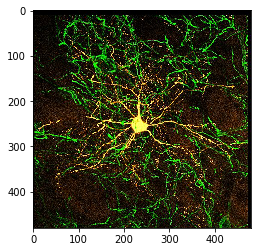

In [14]:
# Plot image form a blob
plt.imshow((Slide & 'image_number=0').fetch1('image_array'));

In [ ]:
# Caching